# Alphalens Analisis

In [3]:
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline.data import factset, USEquityPricing
from quantopian.pipeline.classifiers.fundamentals import Sector
from quantopian.pipeline.factors import Returns, SimpleMovingAverage, CustomFactor, RSI

from alphalens.performance import mean_information_coefficient
from alphalens.utils import get_clean_factor_and_forward_returns
from alphalens.tears import create_information_tear_sheet, create_returns_tear_sheet
from quantopian.pipeline.data.psychsignal import aggregated_twitter_withretweets_stocktwits
from quantopian.pipeline.data.psychsignal import stocktwits
from quantopian.pipeline.data import Fundamentals
from quantopian.pipeline.data import Fundamentals

from quantopian.pipeline.data.factset import Fundamentals as fFundamentals
# Constraint Parameters

/venvs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:11: ZiplineDeprecationWarning: PsychSignal datasets stopped updating on Quantopian on May 1, 2020.
PsychSignal data prior to May 2020 is still available for use on Quantopian;
however, the dataset has stopped updating. For more information see:
https://www.quantopian.com/posts/psychsignal-trader-mood-update

  # This is added back by InteractiveShellApp.init_path()
/venvs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:12: ZiplineDeprecationWarning: PsychSignal datasets stopped updating on Quantopian on May 1, 2020.
PsychSignal data prior to May 2020 is still available for use on Quantopian;
however, the dataset has stopped updating. For more information see:
https://www.quantopian.com/posts/psychsignal-trader-mood-update

  if sys.path[0] == '':


## Define Your Alpha Factor Here

Spend your time in this cell, creating good factors. Then simply run the rest of the notebook to analyze `factor_to_analyze`!

In [24]:
MAX_GROSS_LEVERAGE = 1.0
TOTAL_POSITIONS = 600

# Here we define the maximum position size that can be held for any
# given stock. If you have a different idea of what these maximum
# sizes should be, feel free to change them. Keep in mind that the
# optimizer needs some leeway in order to operate. Namely, if your
# maximum is too small, the optimizer may be overly-constrained.
MAX_SHORT_POSITION_SIZE = 1.0 / TOTAL_POSITIONS
MAX_LONG_POSITION_SIZE = 1.0 / TOTAL_POSITIONS
def make_pipeline():
  
    universe = QTradableStocksUS()

    # We winsorize our factor values in order to lessen the impact of outliers
    # For more information on winsorization, please see
    # https://en.wikipedia.org/wiki/Winsorizing
    total_revenue_winsorized = Fundamentals.total_revenue.latest.winsorize(min_percentile=0.05, max_percentile=0.95)
    regulatory_liabilities_winsorized = Fundamentals.regulatory_liabilities.latest.winsorize(min_percentile=0.05, max_percentile=0.95)
    div_cf_af_winsorized = fFundamentals.div_cf_af.latest.winsorize(min_percentile=0.05, max_percentile=0.95)
    volume_trade_af_winsorized = fFundamentals.volume_trade_af.latest.winsorize(
        min_percentile=0.05,
        max_percentile=0.95
        )
    free_cf_fcfe_af_winsorized = fFundamentals.free_cf_fcfe_af.latest.winsorize(min_percentile=0.05, max_percentile=0.95)
    itc_af = fFundamentals.itc_af.latest
    itc_af_winsorized = itc_af.winsorize(min_percentile=0.05, max_percentile=0.95)
    # Here we combine our winsorized factors, z-scoring them to equalize their influence
    
    
    
    combined_factor = (
         total_revenue_winsorized +
         regulatory_liabilities_winsorized +
         volume_trade_af_winsorized +
         free_cf_fcfe_af_winsorized +
         itc_af_winsorized +
         div_cf_af_winsorized 
    )

    # Build Filters representing the top and bottom baskets of stocks by our
    # combined ranking system. We'll use these as our tradeable universe each
    # day.
    longs = combined_factor.top(TOTAL_POSITIONS//2, mask=universe)
    shorts = combined_factor.bottom(TOTAL_POSITIONS//2, mask=universe)

    # The final output of our pipeline should only include
    # the top/bottom 300 stocks by our criteria
    long_short_screen = (longs | shorts)

    # Create pipeline
    pipe = Pipeline(
        columns={
            'longs': longs,
            'shorts': shorts,
            'combined_factor': combined_factor
        },
        screen=long_short_screen
    )
    return pipe

factor_data = run_pipeline(make_pipeline(), '2017-5-1', '2019-5-1')
pricing_data = get_pricing(factor_data.index.levels[1], '2017-5-1', '2019-5-1', fields='open_price')

## Determine The Decay Rate Of Your Alpha Factor.

Dropped 12.9% entries from factor data: 12.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


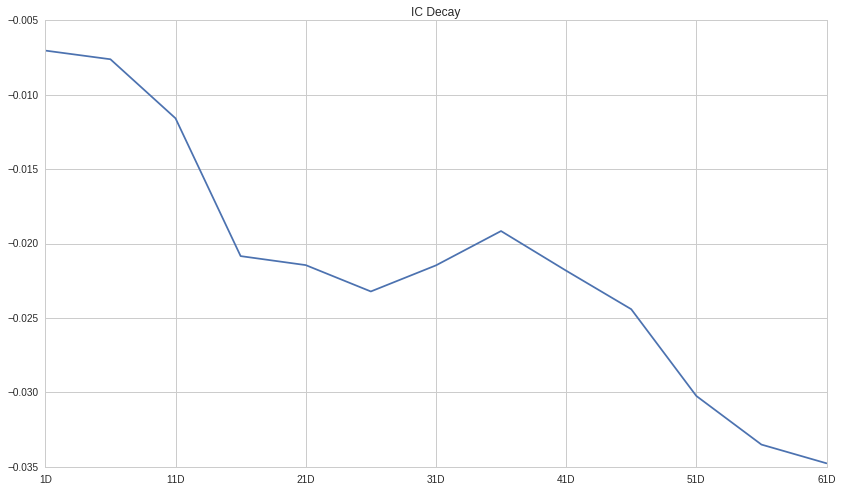

In [25]:
longest_look_forward_period = 63 # week = 5, month = 21, quarter = 63, year = 252
range_step = 5

merged_data = get_clean_factor_and_forward_returns(
    factor = factor_data['combined_factor'],
    prices = pricing_data,
    periods = range(1, longest_look_forward_period, range_step)
)

mean_information_coefficient(merged_data).plot(title="IC Decay")

## Create Group Neutral Tear Sheets

Dropped 2.1% entries from factor data: 2.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Information Analysis


,1D,5D,10D
IC Mean,-0.004,-0.003,-0.002
IC Std.,0.284,0.250,0.230
Risk-Adjusted IC,-0.014,-0.010,-0.009
t-stat(IC),-0.311,-0.230,-0.196
p-value(IC),0.756,0.818,0.845
IC Skew,0.010,-0.048,-0.197
IC Kurtosis,-0.562,-0.341,-0.520


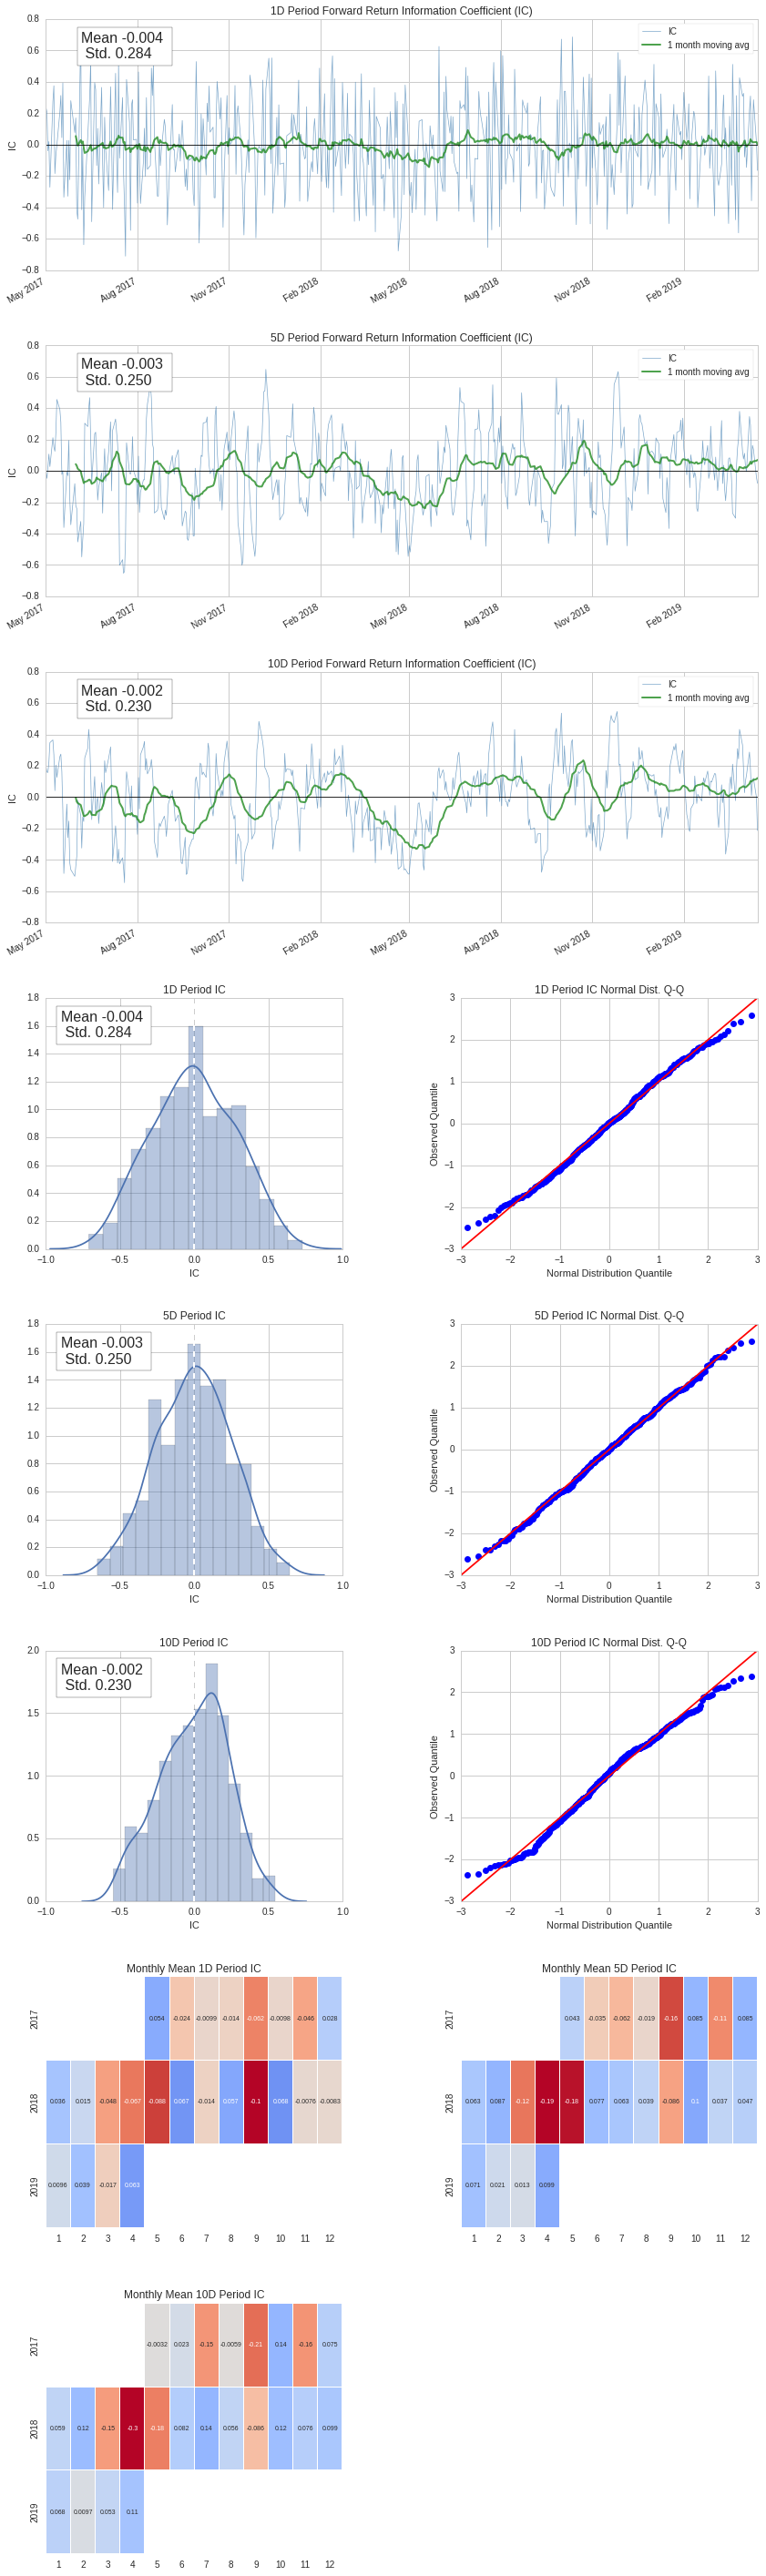

Returns Analysis


,1D,5D,10D
Ann. alpha,-0.017,-0.016,-0.015
beta,0.010,0.005,0.009
Mean Period Wise Return Top Quantile (bps),-1.768,-1.779,-1.732
Mean Period Wise Return Bottom Quantile (bps),0.890,0.891,0.903
Mean Period Wise Spread (bps),-2.658,-2.723,-2.705


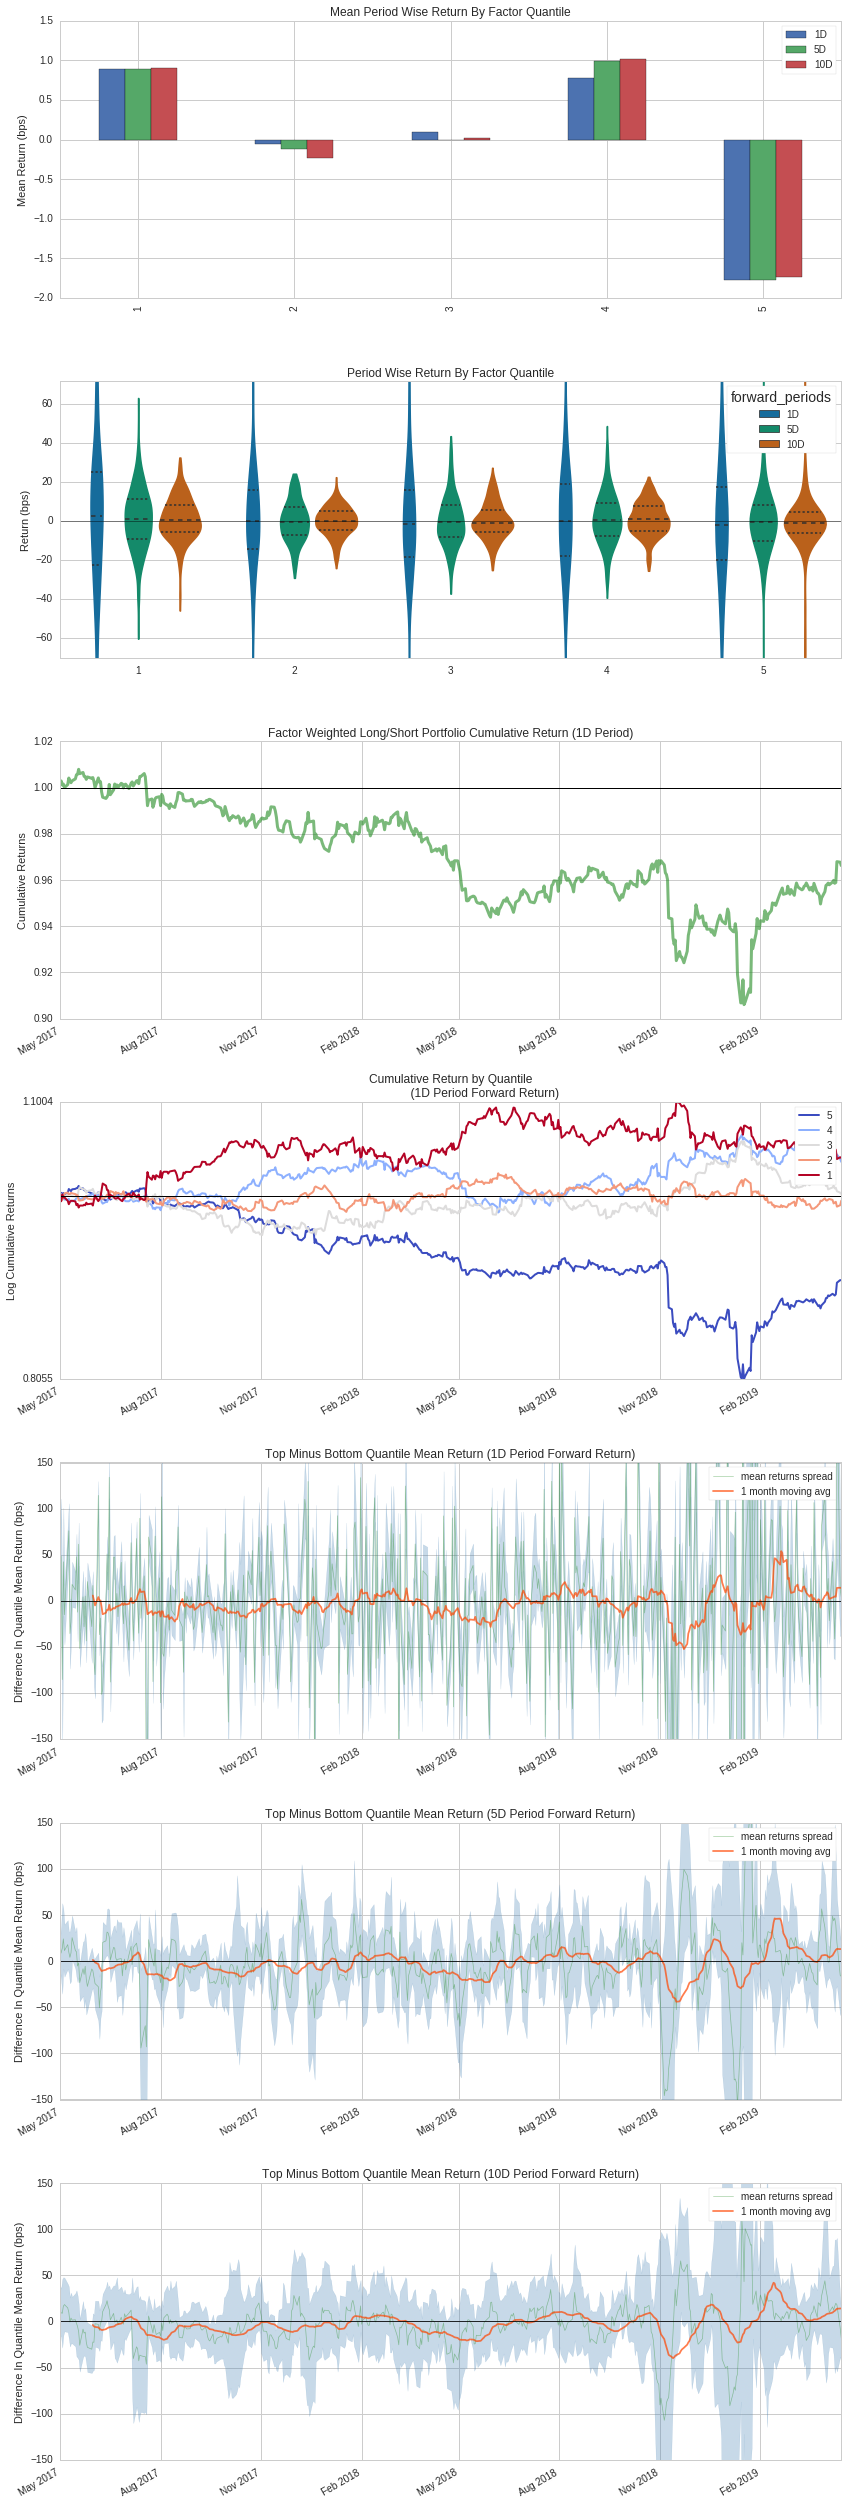

In [26]:
sector_labels, sector_labels[-1] = dict(Sector.SECTOR_NAMES), "Unknown"

merged_data = get_clean_factor_and_forward_returns(
    factor = factor_data['combined_factor'],
    prices = pricing_data,
    periods = (1,5,10)
)

create_information_tear_sheet(merged_data)
create_returns_tear_sheet(merged_data)